# ProWave - WaveNet-based Protein Generation

Authors: Hans Jakob Damsgaard & Lucas Balling

02456 Deep Learning project: ProGen

## Initialization

Run the commmand below if you have not yet installed the [TAPE project](https://github.com/songlab-cal/tape).

In [1]:
#!pip install tape_proteins

#### Importing needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import tape

#### Import the data

We were unable to make the data download script, `download_data.sh`, run from Jupyter, so instead we ran it manually and simply placed the resulting files in the right folder for TAPE to find them. We import all the data in the LMDB format as it is most easily worked with in Python.

In [2]:
from tape.datasets import LanguageModelingDataset

# Data stored under `<data-path>/data`
data_path = '/Users/lucasballing/Desktop/DeepLearningProject/prowave-main/data/'
#data_path = 'E:/Pfam/data/'
train_data   = LanguageModelingDataset(data_path, 'train')
valid_data   = LanguageModelingDataset(data_path, 'valid')
holdout_data = LanguageModelingDataset(data_path, 'holdout')

#### Understanding data features

To get a good understanding of the data provided in the imported dataset, we provide plots of certain features and their ranges. Data is already split into the three required subsets; train, validation, and holdout by TAPE, so it is also interesting to understand this split.

In [3]:
# Split sizes
print(f'Training data has shape ({len(train_data)}, {len(train_data[0])})')
print(f'Validation data has shape ({len(valid_data)}, {len(valid_data[0])})')
print(f'Holdout data has shape ({len(holdout_data)}, {len(holdout_data[0])})')

# Original data columns
from tape.datasets import LMDBDataset
lmdb_train = LMDBDataset(data_path+'pfam/pfam_train.lmdb')
print(f'File data entries look like this: {lmdb_train[0]}')
del lmdb_train

# Data columns - all subsets are taken from the same overall dataset, so the columns are the same
# From combining information from LMDBDataset and LanguageModelingDataset, we know the columns are
# - IUPAC-encoded protein string
# - Input mask (for masked-token prediction)
# - Protein clan
# - Protein family
# The protein ID (i.e., its number within its clan and family) is not included
print(f'Encoded data entries look like this: {train_data[0]}')

Training data has shape (32593668, 4)
Validation data has shape (1715454, 4)
Holdout data has shape (44311, 4)
File data entries look like this: {'primary': 'GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ', 'protein_length': 36, 'clan': 433, 'family': 9122, 'id': '0'}
Encoded data entries look like this: (array([ 2, 11,  7, 23, 25,  9,  8, 21,  7, 15, 13, 11, 16, 11,  5, 13, 15,
       15, 17, 11,  7, 25, 13, 11, 22, 11, 22, 15, 25,  5,  5, 11,  5, 15,
       13, 23, 20,  3]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 433, 9122)


In [22]:
# def setify(data, param = 2):
#     res = set()
#     for i in range(len(data)):
#         res.add(data[i][param])
#     return res
# 
# # Clans in splits
# print(f'Unique clans in training data {len(setify(train_data))}')
# print(f'Unique clans in validation data {len(setify(valid_data))}')
# print(f'Unique clans in holdout data {len(setify(holdout_data))}')
# 
# # Families in splits
# print(f'Unique families in training data {len(setify(train_data, 3))}')
# print(f'Unique families in validation data {len(setify(valid_data, 3))}')
# print(f'Unique families in holdout data {len(setify(holdout_data, 3))}')


In [29]:
from tape.datasets import LMDBDataset
data_path = '/Users/lucasballing/Desktop/DeepLearningProject/prowave-main/data/pfam/pfam_holdout.lmdb' # 'Your File Path here'


#np.train_datav2 = np.array(LMDBDataset(data_path))
#train_datav3 = (LMDBDataset(data_path))
#print("Size of Dataset",train_data[2][3] )
data = np.asarray(holdout_data)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### Creating Some Histograms
This section will plot some histograms of the datasets ot visulise the distribution of Clan and Family ID

KeyboardInterrupt: 

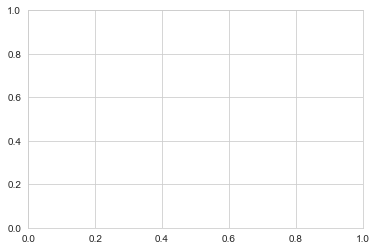

In [30]:
# Creating some large stupid numpy arrays to make it possible to do some histograms
#data = np.zeros((len(holdout_data),2))
#for x in range(0,len(holdout_data)):
#    for h in range(2,4):
#        data[x,(h-2)] = holdout_data[x][h]
#print("Converted the Holdout dataset to numpy")

#data_valid = np.zeros((len(valid_data),2))
#for x in range(0,len(valid_data)):
##    for h in range(2,4):
#        data_valid[x,(h-2)] = valid_data[x][h]
         
#print("Converted the Validation dataset to numpy")


_ = plt.hist(data[:,0], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins - Clan ID")
#plt.Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.xlabel('Clan ID')
plt.ylabel('Number of Cases')
plt.show()


_ = plt.hist(data[:,1], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins - Family ID")
plt.xlabel('Family ID)')
plt.ylabel('Number of Cases')
plt.show()

# Training Set 
_ = plt.hist(data_valid[:,0], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins - Clan ID")
#plt.Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.xlabel('Clan ID')
plt.ylabel('Number of Cases')
plt.show()


_ = plt.hist(data_valid[:,1], bins='auto')  # arguments are passed to np.histogram
plt.title("Proteins - Family ID")
plt.xlabel('Family ID)')
plt.ylabel('Number of Cases')
plt.show()


# Import Tokenizers
#from .tokenizers import TAPETokenizer

# One Hot Encoding the Data
aminoacids = 29



### One-hot encoding over Protein Sequence

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each Protein Amionacid.

| Amionacid    | one-hot encoded vector   |
| ------------- |--------------------------|
| Ala = A        | $= [1, 0, 0, \ldots, 0]$ |
| Asx = B        | $= [0, 1, 0, \ldots, 0]$ |
| Cys = C    | $= [0, 0, 1, \ldots, 0]$ |
| ... | ... |
| pad   | $= [0, 0, 0, \ldots, 1]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

In [28]:
vocab_size = 30
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word, vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(1, vocab_size)
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(holdout_data[1][0], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')
print(test_sentence)
print(holdout_data[1][0])

Our one-hot encoding of 'a' has shape (30,).
Our one-hot encoding of 'a b' has shape (203, 30, 1).
[[[0.]
  [0.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[ 2 20 13 11  5 11 11 23 15 15 21 17 28  8 10 22 19  8 11  7  9 11 23 13
 25 22 22 12 10 15 21 19 25 13 11 16 20  8  5  5 26 11 15 15  8 11 16 17
  8  5 11 15  5 25 22 15 23 10 11 11 21 10 25 12 11 19 11 10  5 25 15 13
 25 15 21 28 15 15  9 23  7 23 23 25 11  9  5 25 11 14 15 14 22 15 19 13
  5 13 19 20 17 25 23 15 25  8 19  9 21 22 15 23 25 10 25 11 19  8 13 19
 15 23  9  5 19  8  5  7  5  5 17 12 20 12 15 19 25 19  8  9 20  9 20 22
 22 21 23 20  9 21 15 22  5 13 21  5  5 11 23  8 25  5  5 16 15  9 19 19
 15 28 20 23  5 28  8  9 26 15 11 23 15 28 23  5 12 28 21 19 22  9 11 21
 25 23 28 2

#### RNN Network for Protein Generation
This section will define the network architecture for the neural network RNN used as the backbone of the ProWave neural network for protein generation.

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

clanidsize = 623
familyids = 15000

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=(vocab_size),
                         hidden_size=1000,
                         num_layers=1,
                         bidirectional=False)
        
        # Output layer
        self.l_out = nn.Linear(in_features=1000,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = MyRecurrentNet()
print(net)

MyRecurrentNet(
  (lstm): LSTM(30, 50)
  (l_out): Linear(in_features=50, out_features=30, bias=False)
)


### Training loop

It's time for us to train our network. In the section below, you will get to put your deep learning skills to use and create your own training loop. You may want to consult previous exercises if you cannot recall how to define the training loop.

In [34]:
# Hyper-parameters
num_epochs = 200

# Initialize a new network
net = MyRecurrentNet()

import torch.optim as optim

# Define a loss function and optimizer for this problem
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.004, momentum=0.6) 

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # zero the parameter gradients
        optimizer.zero_grad()
        output= net(inputs_one_hot)
        batch_loss = criterion(output, targets_idx)

        # forward + backward + optimize
        batch_loss.backward()
        optimizer.step() 
        
        # Compute loss
        # YOUR CODE HERE!
        loss = batch_loss
        
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_idx = [word_to_idx[word] for word in targets]
        
        # Convert input to tensor
        inputs_one_hot = torch.Tensor(inputs_one_hot)
        inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
        
        # Convert target to tensor
        targets_idx = torch.LongTensor(targets_idx)
        
        # Forward pass
        # zero the parameter gradients
        optimizer.zero_grad()
        output= net(inputs_one_hot)
        batch_loss = criterion(output, targets_idx)

        # forward + backward + optimize
        batch_loss.backward()
        optimizer.step() 
        
        # Compute loss
        # YOUR CODE HERE!
        loss = batch_loss
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

        
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
inputs_one_hot = torch.Tensor(inputs_one_hot)
inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
targets_idx = torch.LongTensor(targets_idx)

# Forward pass
outputs = net.forward(inputs_one_hot).data.numpy()

print('\nInput sequence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

NameError: name 'validation_set' is not defined